In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from pylab import rcParams

In [4]:
# per day细粒度的数据分析抖动过于巨大，设置窗口大小为60天（per month）
window_size = 60
look_back = window_size
# 设置LSTM训练集大小
training_set_size = 0.8

In [5]:
data_cs = pd.read_csv('changsha.csv')
data_cd = pd.read_csv('chengdu.csv')
data_heb = pd.read_csv('haerbin.csv')
data_hz = pd.read_csv('hangzhou.csv')
data_jn = pd.read_csv('jinan.csv')
data_wulu = pd.read_csv('wulumuqi.csv')
data_zz = pd.read_csv('zhengzhou.csv')

In [6]:
data_cs.head()

,AQI,PM2_5,PM10,SO2,NO2,CO,O3,Time
0,75.250000,55.200001,65.410004,27.07,25.530001,1.11,27.469999,2013-01-01
1,117.224998,88.779999,101.500000,30.91,32.830002,1.61,23.780001,2013-01-02
2,66.900002,48.520000,55.770000,22.74,24.000000,1.63,26.129999,2013-01-03
3,78.375000,57.700001,55.860001,20.66,21.320000,1.56,26.020000,2013-01-04
4,125.600006,95.480003,81.220001,27.82,28.280001,1.42,19.900000,2013-01-05


In [7]:
def split_date(city_data):
    new_names = ['Year','Month','Day']
    splits = city_data['Time'].str.split('-', expand=True)
    splits.columns = new_names
     # 数据合并
    city_data = city_data.join(splits)
    return city_data



In [8]:
data_cs = split_date(data_cs)
data_cd = split_date(data_cd)
data_heb = split_date(data_heb)
data_hz = split_date(data_hz)
data_jn = split_date(data_jn)
data_wulu = split_date(data_wulu)
data_zz = split_date(data_zz)

In [9]:
data_cs.head()

,AQI,PM2_5,PM10,SO2,NO2,CO,O3,Time,Year,Month,Day
0,75.250000,55.200001,65.410004,27.07,25.530001,1.11,27.469999,2013-01-01,2013,01,01
1,117.224998,88.779999,101.500000,30.91,32.830002,1.61,23.780001,2013-01-02,2013,01,02
2,66.900002,48.520000,55.770000,22.74,24.000000,1.63,26.129999,2013-01-03,2013,01,03
3,78.375000,57.700001,55.860001,20.66,21.320000,1.56,26.020000,2013-01-04,2013,01,04
4,125.600006,95.480003,81.220001,27.82,28.280001,1.42,19.900000,2013-01-05,2013,01,05


In [10]:
print(data_cs.dtypes)

AQI      float64
PM2_5    float64
PM10     float64
SO2      float64
NO2      float64
CO       float64
O3       float64
Time      object
Year      object
Month     object
Day       object
dtype: object


In [11]:
data_cs[['Year', 'Month', 'Day']] = data_cs[['Year', 'Month', 'Day']].astype("int64")
data_cd[['Year', 'Month', 'Day']] = data_cd[['Year', 'Month', 'Day']].astype("int64")
data_heb[['Year', 'Month', 'Day']] = data_heb[['Year', 'Month', 'Day']].astype("int64")
data_hz[['Year', 'Month', 'Day']] = data_hz[['Year', 'Month', 'Day']].astype("int64")
data_jn[['Year', 'Month', 'Day']] = data_jn[['Year', 'Month', 'Day']].astype("int64")
data_wulu[['Year', 'Month', 'Day']] = data_wulu[['Year', 'Month', 'Day']].astype("int64")
data_zz[['Year', 'Month', 'Day']] = data_zz[['Year', 'Month', 'Day']].astype("int64")

In [12]:
data_cs.head()

,AQI,PM2_5,PM10,SO2,NO2,CO,O3,Time,Year,Month,Day
0,75.250000,55.200001,65.410004,27.07,25.530001,1.11,27.469999,2013-01-01,2013,1,1
1,117.224998,88.779999,101.500000,30.91,32.830002,1.61,23.780001,2013-01-02,2013,1,2
2,66.900002,48.520000,55.770000,22.74,24.000000,1.63,26.129999,2013-01-03,2013,1,3
3,78.375000,57.700001,55.860001,20.66,21.320000,1.56,26.020000,2013-01-04,2013,1,4
4,125.600006,95.480003,81.220001,27.82,28.280001,1.42,19.900000,2013-01-05,2013,1,5


In [75]:
def smooth(city_data,column_name,window_size):
    temp_data = city_data[column_name]
    temp = []
    temp_sum = 0
    for i in range(len(temp_data)):
        temp_sum += temp_data[i]
        if np.mod(i+1,window_size)==0:
            temp.append(temp_sum/window_size)
            temp_sum = 0
    return temp

In [76]:
rcParams['figure.figsize'] = (10,8)
# 定义scaler：MinMax
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

# 归一化
def normalization(city_data):
    AQI_data = scaler.fit_transform(city_data.values.reshape(-1,1))
    return AQI_data

# 反归一化
def inverse_normalization(city_data):
    AQI_inverse = scaler.inverse_transform(city_data)
    return AQI_inverse

# 划分数据
def split(city_data):
    split = int(len(city_data)*training_set_size)
    train = city_data[:split]
    test = city_data[split+1:]
    return train,test

# 画图
def plot(title,ylabel,xlabel,data,sta=0):
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.plot(data[sta:])
def plot_AQI(city_data,window_size):
    AQI_list = smooth(city_data,'AQI',window_size)
    plot('AQI','time',AQI_list)

In [77]:
train_set_zz,test_set_zz = split(data_zz['AQI'])
train_set_zz = normalization(train_set_zz)
test_set_zz = normalization(test_set_zz)

In [78]:
def creat_dataset(dataset,look_back):
    data_x = []
    data_y = []
    for i in range(len(dataset)-look_back):
        data_x.append(dataset[i:i+look_back])
        data_y.append(dataset[i+look_back])
    return np.asarray(data_x).reshape(-1, 1, look_back),np.asarray(data_y).reshape(-1, 1, 1)#将训练数据调整成pytorch中lstm算法的输入维度  (seq_len,batch_size(指有几个batch),input_size) #将目标值调整成pytorch中lstm算法的输出维度



x_train_zz, y_train_zz = creat_dataset(train_set_zz,look_back)

In [79]:
epoch = 1000
lr = 0.08
hidden_layer_size = 32
num_layers = 4
# 使用gpu加速训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
loss_list = []

cuda


In [80]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        # input_size = lookback
        self.lstm = nn.LSTM(look_back,hidden_layer_size,num_layers)
        #线性拟合 output_size = 1
        self.out = nn.Linear(hidden_layer_size,1) 
        
        
    def forward(self,x):
        x1,_ = self.lstm(x)
        a,b,c = x1.shape
        # 线性层输入:二维数据，stm输出:三维数据
        # 输出的特征维度不能变
        out = self.out(x1.view(-1,c))
        # 循环神经网络，把二维output调整成三维数据，下一次循环使用
        out1 = out.view(a,b,-1)
        return out1

In [81]:
rnn = RNN().to(device)
print(rnn)
optimizer = torch.optim.Adam(rnn.parameters(),lr = 0.02)
loss_func = nn.MSELoss().to(device)

RNN(
  (lstm): LSTM(60, 32, num_layers=4)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [82]:
def train(x_train, y_train):    
    for i in range(epoch):
        x = torch.from_numpy(x_train).type(torch.FloatTensor).to(device)
        y = torch.from_numpy(y_train).type(torch.FloatTensor).to(device)
        out = rnn(x).to(device)
        loss = loss_func(out,y)
        loss_list.append(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if np.mod(i+1,5)==0:
            print('Epoch:{}, Loss:{:.5f}'.format(i+1, loss.item()))
            
train(x_train_zz,y_train_zz)

Epoch:5, Loss:0.02031
Epoch:10, Loss:0.01596
Epoch:15, Loss:0.01509
Epoch:20, Loss:0.01456
Epoch:25, Loss:0.01395
Epoch:30, Loss:0.01356
Epoch:35, Loss:0.01299
Epoch:40, Loss:0.01273
Epoch:45, Loss:0.01216
Epoch:50, Loss:0.01100
Epoch:55, Loss:0.02057
Epoch:60, Loss:0.01349
Epoch:65, Loss:0.01040
Epoch:70, Loss:0.01030
Epoch:75, Loss:0.00920
Epoch:80, Loss:0.00904
Epoch:85, Loss:0.00868
Epoch:90, Loss:0.00852
Epoch:95, Loss:0.00819
Epoch:100, Loss:0.00797
Epoch:105, Loss:0.00766
Epoch:110, Loss:0.00729
Epoch:115, Loss:0.00686
Epoch:120, Loss:0.00635
Epoch:125, Loss:0.00575
Epoch:130, Loss:0.00529
Epoch:135, Loss:0.00531
Epoch:140, Loss:0.00484
Epoch:145, Loss:0.00442
Epoch:150, Loss:0.00417
Epoch:155, Loss:0.00405
Epoch:160, Loss:0.00388
Epoch:165, Loss:0.00360
Epoch:170, Loss:0.00338
Epoch:175, Loss:0.00371
Epoch:180, Loss:0.00375
Epoch:185, Loss:0.00346
Epoch:190, Loss:0.00309
Epoch:195, Loss:0.00288
Epoch:200, Loss:0.00266
Epoch:205, Loss:0.00255
Epoch:210, Loss:0.00240
Epoch:215, L

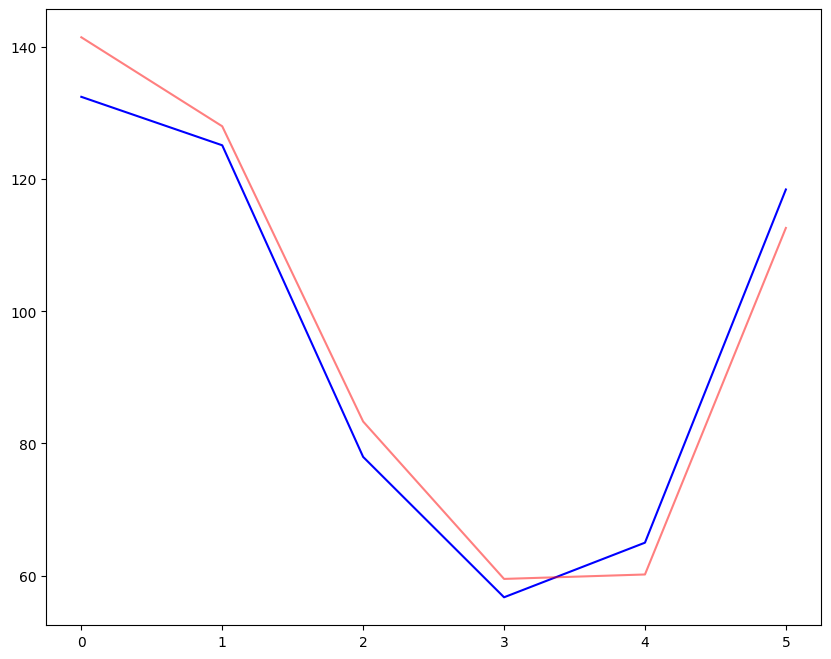

In [83]:
# 测试
rnn.eval()
#构建数据集
x_test_zz,y_test_zz = creat_dataset(test_set_zz,look_back)

def test_rnn(x_test,y_test):
    y_pred = rnn(torch.from_numpy(x_test).type(torch.FloatTensor).to(device))

    pred = y_pred.data.cpu().numpy().reshape(-1,1)
    test = y_test.reshape(-1,1)
    pred_list = []
    test_list = []
    pred_sum = 0
    test_sum = 0

    for i in range(len(pred)):
        pred_sum += pred[i]
        test_sum += test[i]
        if np.mod(i+1,look_back)==0:
            pred_list.append(pred_sum/look_back)
            test_list.append(test_sum/look_back)
            pred_sum = 0
            test_sum = 0
    
    plt.plot(inverse_normalization(test_list),color='b')
    plt.plot(inverse_normalization(pred_list),color='r',alpha=0.5)
    plt.show()

test_rnn(x_test_zz,y_test_zz)

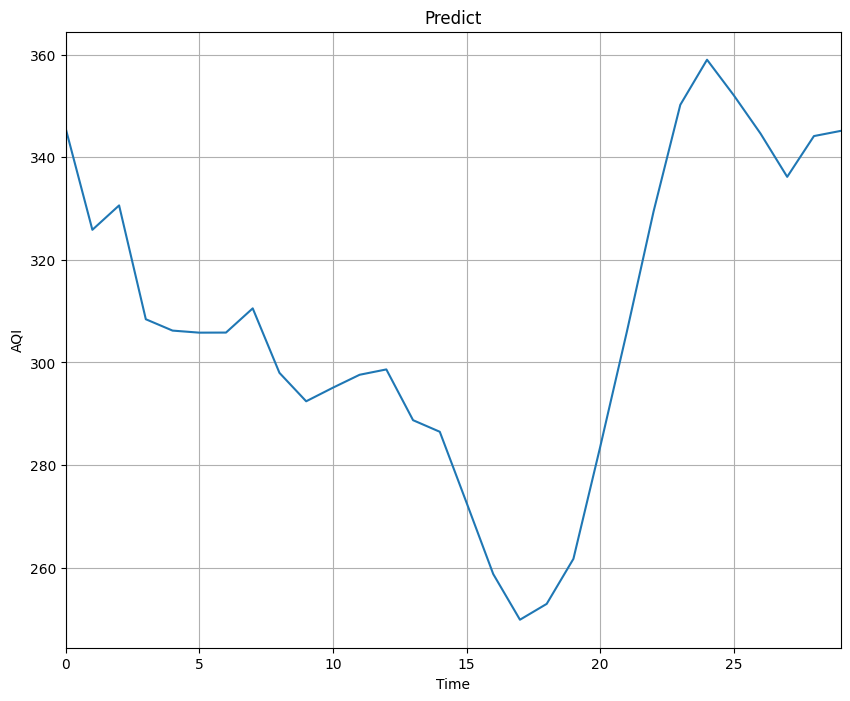

In [84]:
time_forward = 30

# 迭代的将预测得到的第a天的数据加入数据集用作预测第a+1天
def fut_iter(in_seq):
    x = torch.from_numpy(in_seq).type(torch.FloatTensor).to(device)
    out_data = rnn(x).to(device)
    
    return out_data
def pred_future(city_data,time_forward=30):
    AQI_data = normalization(city_data['AQI'])
    # 创建初始数据集
    data,_ = creat_dataset(AQI_data,look_back)
    pred = rnn(torch.from_numpy(data).type(torch.FloatTensor).to(device))
    pred = pred.data.cpu().numpy().reshape(-1,1)

    in_seq = np.delete(data[-1,0],0)
    in_seq = np.append(in_seq,pred[-1]).reshape(1,-1,look_back)
    for i in range(time_forward):
        out = fut_iter(in_seq).item()
        pred = np.append(pred,out)
        in_seq = np.delete(in_seq[-1,0],0)
        # 扩增数据集
        in_seq = np.append(in_seq,out).reshape(1,-1,look_back)
    pred = pred.reshape(-1,1)
    # 反归一化
    pred = inverse_normalization(pred)
    plot('Predict','AQI','Time',data=pred,sta=-time_forward)
    plt.show()
    return pred[-time_forward:]
result_data=pred_future(data_zz,time_forward)

In [85]:
result_df=pd.DataFrame(result_data,columns=['AQI'])
result_df

,AQI
0,345.618344
1,325.843821
2,330.597182
3,308.411835
4,306.200137
5,305.799101
6,305.815531
7,310.533577
8,297.966135
9,292.422831


In [86]:
result_df.to_csv('re_zhengzhou.csv',index=0)